## HeartFailure data preprocessing

### Importing necessary libraries

In [1]:
import os
import sys
current_directory=os.getcwd()
parent_directory=os.path.dirname(current_directory)
sys.path.append(parent_directory)


In [2]:
import numpy as np
from library.generators.NextConvGeN import NextConvGeN


2024-01-31 12:04:47.289901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 12:04:47.289920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC
from fdc.clustering import *

In [4]:
import pandas as pd

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Importing data

In [6]:
data=pd.read_csv('survey lung cancer.csv')

In [7]:
np.random.seed(42)
data=data.sample(frac=1)

In [8]:
gender_mod= {'GENDER': {'F':1,'M':0}}
data.replace(gender_mod,inplace=True)


In [9]:
lung_cancer_mod= {'LUNG_CANCER': {'YES':1,'NO':0}}
data.replace(lung_cancer_mod,inplace=True)


In [10]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/LungCancer.csv")
data.to_csv(output_file_path, index=False)

In [11]:
data['LUNG_CANCER'].value_counts()

1    270
0     39
Name: LUNG_CANCER, dtype: int64

In [12]:
data.drop(['LUNG_CANCER'],axis=1, inplace=True)

In [13]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [14]:
np.random.seed(42)
data=data.sample(frac=1)

In [15]:
values=['AGE','SMOKING','GENDER','CHRONIC DISEASE','ALCOHOL CONSUMING','SHORTNESS OF BREATH',
'YELLOW_FINGERS','ANXIETY','PEER_PRESSURE','WHEEZING','COUGHING','SWALLOWING DIFFICULTY',
'CHEST PAIN','FATIGUE ','ALLERGY ']

In [16]:
data=data[values]

### UMAP on entire data

In [17]:
from fdc.fdc import feature_clustering

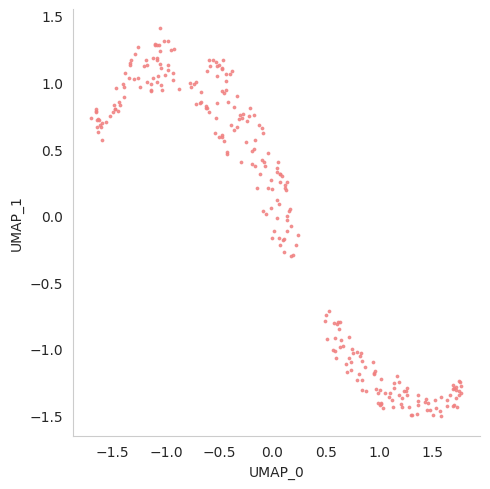

In [18]:
np.random.seed(42)
umap_emb=feature_clustering(30,0.1,'euclidean',data,True)

### Feature-type Distributed Clustering (FDC)

In [19]:
cont_list=['AGE']

ord_list=['SMOKING','GENDER','CHRONIC DISEASE','ALCOHOL CONSUMING','SHORTNESS OF BREATH']

nom_list=['YELLOW_FINGERS','ANXIETY','PEER_PRESSURE','WHEEZING','COUGHING','SWALLOWING DIFFICULTY','CHEST PAIN','FATIGUE ','ALLERGY ']

target = ['LUNG_CANCER']


FDC.normalize (init): 0.00001 / 0.000s


FDC.normalize (clustering CONT): 1.70443 / 1.704s


FDC.normalize (clustering ORD): 2.08391 / 3.788s


FDC.normalize (clustering NOM): 1.42775 / 5.216s
FDC.normalize (concat): 0.00007 / 5.216s


FDC.normalize (umap 5 -> 2): 0.93976 / 6.156s
FDC.normalize (array -> DataFrame): 0.00025 / 6.156s


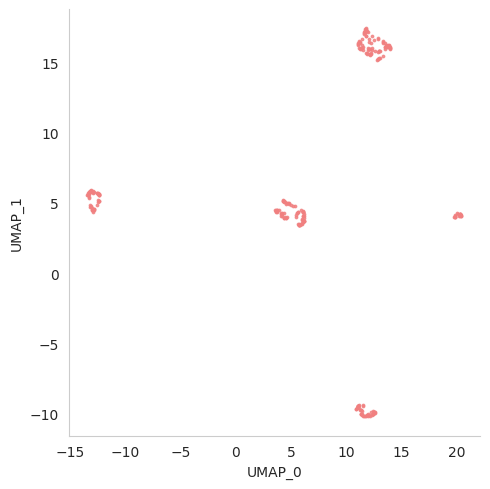

FDC.normalize (plotting): 0.40735 / 6.564s
FDC.normalize (array -> DataFrame): 0.00018 / 6.564s
FDC.normalize (total): 0.00001 / 6.564s


In [20]:
from fdc.fdc import feature_clustering, canberra_modified, Clustering, FDC

np.random.seed(42)

fdc = FDC(clustering_cont=Clustering('euclidean')
          , clustering_ord=Clustering('canberra')
          , clustering_nom=Clustering('hamming')
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, nomial=nom_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,cont_list=cont_list, nom_list=nom_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

In [21]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/LungCancer.json")

In [22]:
import json

features = {
    "cont_list": cont_list,
    "nom_list": nom_list,
    "ord_list": ord_list,
    "target": target
}

with open(output_file_path, "w") as json_file:
    json.dump(features, json_file)

### Clustering using K-means

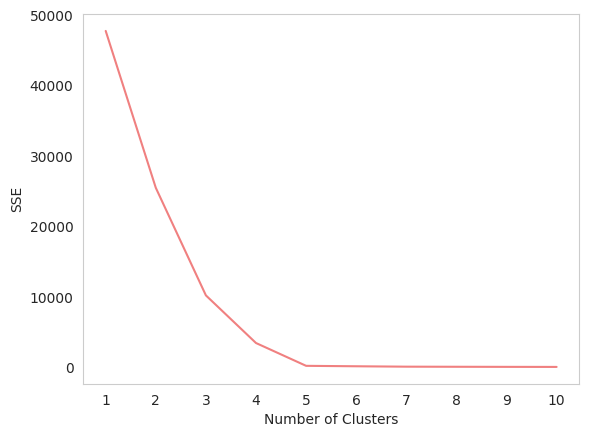

In [23]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(FDC_emb_low)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [24]:
def find_optimal_cluster(FDC_emb_low):
    silhouette_scores = []

    for n_clusters in list(range(2, 9)):
        km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)

        km.fit(FDC_emb_low)

        labels = km.labels_

        # Compute the silhouette score
        silhouette_avg = silhouette_score(FDC_emb_low, labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

In [25]:
find_optimal_cluster(FDC_emb_low)

[0.58071524,
 0.684203,
 0.82214135,
 0.92764986,
 0.80723065,
 0.7310681,
 0.7270884]

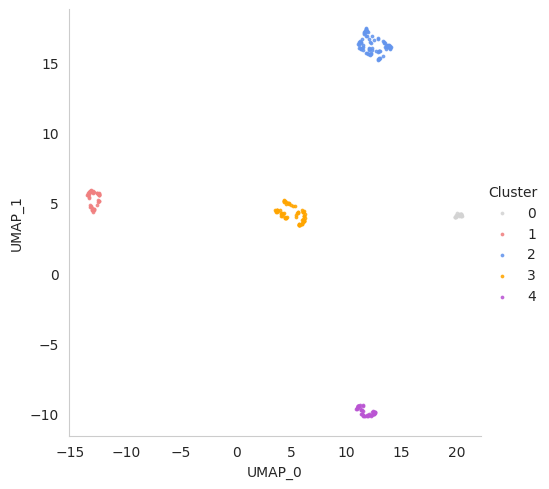

In [26]:
from fdc.clustering import *
np.random.seed(42)
clustering=Clustering(FDC_emb_low,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(5)

In [27]:
cluster_counts

array([19, 49, 89, 73, 45])

In [28]:
data['Target']=cluster_list

In [29]:
output_file_path=os.path.join(parent_directory,"PreprocessedDatasets/SSLungCancer.csv")
data.to_csv(output_file_path, index=False)

In [30]:
data

,AGE,SMOKING,GENDER,CHRONIC DISEASE,ALCOHOL CONSUMING,SHORTNESS OF BREATH,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,WHEEZING,COUGHING,SWALLOWING DIFFICULTY,CHEST PAIN,FATIGUE,ALLERGY,Target
30,49,1,1,2,2,2,1,1,2,1,2,1,1,1,2,3
139,59,1,1,1,1,2,1,1,2,2,2,1,2,2,1,3
195,63,1,1,1,1,2,2,1,1,2,2,1,1,1,1,3
126,70,1,1,2,2,2,1,1,2,1,2,1,1,1,2,4
215,69,2,0,1,1,1,1,1,2,1,1,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,68,2,0,1,1,1,1,2,1,1,1,1,1,2,1,0
71,52,2,0,1,2,2,1,1,1,2,2,1,2,2,1,2
106,66,2,0,1,2,2,1,1,1,2,2,1,1,2,1,1
270,65,2,0,2,1,1,2,2,2,1,1,1,1,1,1,2
